# Understanding precipitation variability under climate change

This notebook creates a figure of precip changes (both mean and variability) as a function of GMST. It essentially replicates Figure 3 in [this paper](https://www.nature.com/articles/s41598-017-17966-y). It was a product of the NCAR CMIP6 Hackathon Oct 16-18, 2019.

Authors:
- Angeline Pendergrass, NCAR
- Chiara Lepore, LDEO
- Kevin Schwarzwald, Columbia Univ.
- Ian Bolliger, UC Berkeley

Currently, this is designed to work using the environment specified in the `environment.yml` file contained in this repo, on either the NCAR supercomputing infrastructure or on [ocean.pangeo.io](ocean.pangeo.io)

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
#import gcsfs
from tqdm.autonotebook import tqdm
from scipy import signal
import util

/ncar/usr/jupyterhub/envs/cmip6-201910/lib/python3.7/site-packages/tqdm/autonotebook.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
# Experiments to process
experiment_ids = ['historical', 'ssp370']

# Seasons to process
seasons = ['all','DJF','JJA']


# Time slices (future) to process
time_slices = ([['1991','2020'],
                ['2001','2030'],
                ['2011','2040'],
                ['2021','2050'],
                ['2031','2060'],
                ['2041','2070'],
                ['2051','2080'],
                ['2061','2090'],
                ['2071','2100']])


In [3]:
# total time range of assets we would need
time_range = [1976, 2100]

# variables we need to aggregate
# There is no huss on the cloud! abandon for now
# variable_ids = ['pr','tas','huss']
variable_ids = ['pr','tas']

# tables needed
table_ids = ['Amon']

# temporally constant vars needed for aggregation
const_vars = ['sftlf','areacella']

## Finding data

First, we get a list of all the data assets we will need to read in for this analysis.

In [4]:
col = util.load_data_catalog()

In [5]:
# subset to overall things we're looking at
subset = col.search(experiment_id=experiment_ids, 
                    variable_id=variable_ids,
                    table_id=table_ids)

In [6]:
# subset to models that have all the variables we want
# (monthly tas, pr, huss) for both historical and ssp370
uni_dict = subset.unique(['source_id','table_id','variable_id'])
models = set(uni_dict['source_id']['values']) # all the models
for v in variable_ids:
    for e in experiment_ids:
        cat = subset.search(variable_id=v, experiment_id=e)
        models = models.intersection({model for model in cat.df.source_id.unique().tolist()})

models = list(models)

# subset to relevant models
col_vars = subset.search(source_id=models)

In [7]:
if util.is_ncar_host():
        ## subset on years
    model_df = col_vars.df.copy()

    # clean up dates
    years = model_df.time_range.str.split('-', expand=True).apply(lambda ser: ser.str[:4]).astype(int)

    # subset
    valid = ((years[0]>= time_range[0]) & (years[0] <= time_range[1]) | 
             (years[1]>= time_range[0]) & (years[1] <= time_range[1]))

    # return to our collection
    col_vars.df = model_df[valid]

In [8]:
## get all the appropriate constant assets

# subset full collection to models we're using
models = col_vars.unique('source_id')['source_id']['values']
subset_const = col.search(source_id=models, variable_id=const_vars)

# subset to models that have all the variables we want
# (monthly tas, pr, huss)
uni_dict = subset_const.unique(['source_id','variable_id'])
models_const = set(uni_dict['source_id']['values']) # all the models
for v in const_vars:
    cat = col.search(variable_id=v)
    models_const = models_const.intersection({model for model in cat.df.source_id.unique().tolist()})

models = list(models_const)

# subset to relevant models
col_const = subset_const.search(source_id=models)

Finding fixed grid assets to use for our models. **NOTE (IB, 10/17/19)**: For now, I'm assuming that any grid with the same `grid_label` and `source_id` will be the same. Hopefully this is true. This is to avoid the complicated fuzzy matching algorithm needed to deal with the varied ways in which modeling groups save `fx` tables.

In [9]:
single_const_df = col_const.df.copy().groupby(['source_id','grid_label','variable_id']).first().reset_index()
col_const.df = single_const_df

**NOTE (IB, 10/17/19)**: Here I am subsetting to only the models that have `areacella` and `sftlf`. I'm hoping that we'll have that data at some point for all models, so am not going through the logistical challenge of calculating these values for models that don't have them. If we need to, we can do that at some point

In [10]:
col_vars = col_vars.search(source_id=models)

Now, back to our regularly scheduled programming...

First, load dask cluster to deal with large data

## Note:  this has a workaround to use just one variant - this will need to be fixed later

In [11]:
### NEW load data function
# Function to load data: df_data has the catalogue of the variable of interest
def load_data(col_vars, varname, modelname, expt_id):
    """
    Load data for given variable, source and expt ids.
    """
    col_var_exp_mod = col_vars.search(variable_id=varname).search(source_id=modelname).search(experiment_id=expt_id)
    dict_var_exp_mod=col_var_exp_mod.to_dataset_dict()
    ds_allvariants = dict_var_exp_mod[list(dict_var_exp_mod)[0]]
    # for consistency with existing code, restrict to just one variant for now
#    thisds.member_id[0].item(0)
    thisds = dict_var_exp_mod[list(dict_var_exp_mod)[0]]
    firstvariantlabel = thisds.member_id[0].item(0)
    ds = thisds.sel(member_id=firstvariantlabel)
    return ds


In [12]:
def spatial_average(field,lat_or_spatial_weights,latitude):
    if lat_or_spatial_weights is not None:
        field_mean = np.average(field,weights=lat_or_spatial_weights.areacella)
    else:
        # Use the cosine of the converted latitudes as weights for the average
        field_mean = np.average(field.mean("lon"),weights=np.cos(np.deg2rad(latitude)))
    return field_mean

In [14]:
# Function to get mean and variability and their changes
def mean_dtas_calc(data_tmp,seas='all', weights_in=None):
    # Set if season is 'all'
    if seas=="all":
        seas = ['DJF','MAM','JJA','SON']
    
    # Load
    mu_hist = data_tmp['hist'].load()
    mu_futr = data_tmp['futr'].load()
    
        
    # Calculate mean of raw series
    mu_hist = (data_tmp['hist'].sel(time=data_tmp['hist'].time.dt.season.isin(seas))
               .tas.mean('time'))
    mu_futr = (data_tmp['futr'].sel(time=data_tmp['futr'].time.dt.season.isin(seas))
               .tas.mean('time'))

    # Take the spatial average 
    latitude=data_tmp['hist'].lat
    mu_histG = spatial_average(mu_hist,weights_in,latitude)
    mu_futrG = spatial_average(mu_futr,weights_in,latitude)
        
    dtasG = mu_futrG-mu_histG

    # Out 
    outp = xr.Dataset(
        data_vars = {'dtasG':    ([],dtasG)}
        )


#     return(outp)
    return(dtasG)

In [16]:
tdata = {}

times = []
for mod_name in tqdm(models):
    print('\n\nStarting '+mod_name+'\n')
    ds_hist = load_data(col_vars, 'tas', mod_name, experiment_ids[0]).sel(time=slice('1976', '2005'))
    ds_ssp  = load_data(col_vars, 'tas', mod_name, experiment_ids[1])

    try: # try getting areacella data
        ds_areacella = load_data(col_vars, 'areacella', mod_name, experiment_ids[0])

    except: #if not available, flag it as 0. It will use np.cos(lat)
        ds_areacella = None

    tdata[mod_name] = {}

    for time_slice in time_slices:
        print('Begin processing time slice '+time_slice[0]+'-'+time_slice[1])
        if ds_ssp.time.max().dt.year+1<int(time_slice[1]):
            print("Future time series only goes until "+str(ds_ssp.time.max().dt.year.values))
            break

        # Get corresponding temporal slice of data and stage it
        ds_ssp_tmp = ds_ssp.sel(time=slice(time_slice[0],time_slice[1]))
        tdata[mod_name]["t"+time_slice[0]] = {'hist':ds_hist,'futr':ds_ssp_tmp}


        dtasG = mean_dtas_calc(tdata[mod_name]['t'+time_slice[0]],
                                                               seas = 'all', weights_in=ds_areacella)

        times.append(xr.Dataset( {mod_name: ([ 'time'],  np.atleast_1d(dtasG))},
                          coords = { 'time': ('time',[int(time_slice[0])])}))

        print(' processed!')

        print(time_slice[0]+'-'+time_slice[1]+' processed!')

    print(mod_name+' processed!')





Starting MRI-ESM2-0


xarray will load netCDF datasets with dask using a single chunk for all arrays.
For effective chunking, please provide chunks in cdf_kwargs.
For example: cdf_kwargs={'chunks': {'time': 36}}

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)

xarray will load netCDF datasets with dask using a single chunk for all arrays.
For effective chunking, please provide chunks in cdf_kwargs.
For example: cdf_kwargs={'chunks': {'time': 36}}

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)

xarray will load netCDF datasets with dask using a single chunk for all arrays.
For effective chunking, please provide chunks in cdf_kwargs.
For example: cdf_kwargs={'chunks': {'time': 36}}

--> The keys in the returned dict

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [18]:
temp_da = xr.combine_by_coords(times)

In [19]:
temp_da.to_dataframe()

,CNRM-CM6-1,CanESM5,MRI-ESM2-0
time,,,
1991,0.626013,1.084301,0.648412
2001,0.743610,1.357900,0.799562
2011,0.889517,1.631635,0.968926
2021,1.124932,2.050670,1.202015
2031,1.516358,2.592989,1.534743
2041,1.951628,3.106144,1.862110
2051,2.470436,3.683948,2.197812
2061,3.006025,4.283331,2.521100
2071,3.605183,4.958815,2.862054


In [20]:
temp_da.to_dataframe().to_csv('tresults.csv')

In [13]:
tresults_new=pd.read_csv('tresults.csv',index_col=0)
tresults_new

,CNRM-CM6-1,CanESM5,MRI-ESM2-0
time,,,
1991,0.626013,1.084301,0.648412
2001,0.743610,1.357900,0.799562
2011,0.889517,1.631635,0.968926
2021,1.124932,2.050670,1.202015
2031,1.516358,2.592989,1.534743
2041,1.951628,3.106144,1.862110
2051,2.470436,3.683948,2.197812
2061,3.006025,4.283331,2.521100
2071,3.605183,4.958815,2.862054


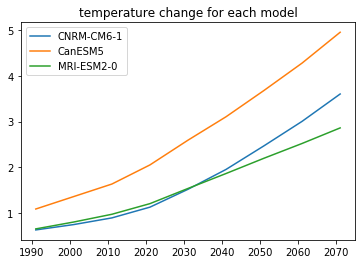

In [14]:
plt.plot(tresults_new)
plt.title('temperature change for each model')
plt.legend(tresults_new.columns)

# PRECIP

In [15]:
# Function to get mean and variability and their changes
def mean_var_calc(data_tmp,seas='all',weights_in=None):
    # Set if season is 'all'
    if seas=="all":
        seas = ['DJF','MAM','JJA','SON']    

    # Calculate mean of raw series
    mu_hist = (data_tmp['hist'].sel(time=data_tmp['hist'].time.dt.season.isin(seas))
               .pr.mean('time'))
    mu_futr = (data_tmp['futr'].sel(time=data_tmp['futr'].time.dt.season.isin(seas))
               .pr.mean('time'))
    
    # Take the spatial average 
    latitude=data_tmp['hist'].lat
    mu_histG = spatial_average(mu_hist,weights_in,latitude)
    mu_futrG = spatial_average(mu_futr,weights_in,latitude)

    # Calculate standard deviation of detrended series
    sd_hist = (xr.apply_ufunc(signal.detrend, data_tmp['hist']['pr'],
                                    kwargs={'axis': 0}).where(~data_tmp['hist'].isnull())
               .sel(time=data_tmp['hist'].time.dt.season.isin(seas))
               .std("time"))
    sd_futr = (xr.apply_ufunc(signal.detrend, data_tmp['futr']['pr'],
                                    kwargs={'axis': 0}).where(~data_tmp['futr'].isnull())
               .sel(time=data_tmp['futr'].time.dt.season.isin(seas))
               .std("time"))

    #Perhaps it's without the final .pr? 
    #sd_hist = (xr.apply_ufunc(signal.detrend, data_tmp['hist'].fillna(0),
    #                                kwargs={'axis': 0}).where(~data_tmp['hist'].isnull())
    #           .sel(time=data_tmp['hist'].time.dt.season.isin(seas))
    #           .std("time"))
    #sd_futr = (xr.apply_ufunc(signal.detrend, data_tmp['futr'].fillna(0),
    #                                kwargs={'axis': 0}).where(~data_tmp['futr'].isnull())
    #           .sel(time=data_tmp['futr'].time.dt.season.isin(seas))
    #           .std("time"))
    #Need to take it apart to sort it out
    
    
    # Take the spatial average of variance
    # Calculate variance
    var_hist = sd_hist ** 2    
    var_histG = spatial_average(var_hist,weights_in,latitude)
    sd_histG = np.sqrt(var_histG)

    var_futr = sd_futr ** 2
    var_futrG = spatial_average(var_futr,weights_in,latitude)
    sd_futrG = np.sqrt(var_futrG)
    
    # calculate changes
    dmuG = mu_futrG/mu_histG
    dsdG = sd_futrG/sd_histG

    dmuG = xr.DataArray(dmuG, coords=[], dims=[]).rename('dmuG')
    dsdG = xr.DataArray(dsdG, coords=[], dims=[]).rename('dsdG')
    
    return(dmuG,dsdG)


In [16]:
data = {}
modeldata = []

for mod_name in tqdm(models):
    print('\n\nStarting '+mod_name+'\n')
    ds_hist = load_data(col_vars, 'pr', mod_name, experiment_ids[0]).sel(time=slice('1976', '2005'))
    ds_ssp  = load_data(col_vars, 'pr', mod_name, experiment_ids[1])

    try: # try getting areacella data
        ds_areacella = load_data(col_vars, 'areacella', mod_name, experiment_ids[0])
    except: #if not available, flag it as 0. It will use np.cos(lat)
        ds_areacella = None

    data[mod_name] = {}

    times = []
    for time_slice in time_slices:
        print('Begin processing time slice '+time_slice[0]+'-'+time_slice[1])
        if ds_ssp.time.max().dt.year+1<int(time_slice[1]):
            print("Future time series only goes until "+str(ds_ssp.time.max().dt.year.values))
            break

       # Get corresponding temporal slice of data and stage it
        ds_ssp_tmp = ds_ssp.sel(time=slice(time_slice[0],time_slice[1]))
        data[mod_name]["t"+time_slice[0]] = {'hist':ds_hist,'futr':ds_ssp_tmp}



## implement this later, for now just do DJF 
        seasons_loop = []
        for seas in seasons:
            # Calculate means, sds,...
            dmuG , dsdG = mean_var_calc(data[mod_name]['t'+time_slice[0]],seas, weights_in = ds_areacella)
            # concatenate dataarrays
            # I will have to keep the mu_hist, mu_futr, sd_hist, sd_futr
            # out because they can have different lat and lon
#                 das = [mu_hist.rename('mu_hist'),
#                        mu_futr.rename('mu_futr'),
#                        dmuG,
#                        sd_hist.rename('sd_hist'), 
#                        sd_futr.rename('sd_futr'), dsdG]
            das = [dmuG, dsdG]
            das_expanded = [da.expand_dims(['model_name', 'time', 'season']) for da in das]
            dasb = xr.merge(das_expanded)
            dasb.coords['model_name'] = 'model_name', [mod_name]
            dasb.coords['time'] = 'time', [int(time_slice[0])]
            dasb.coords['season'] = 'season', [seas]
            seasons_loop.append(dasb)
            #print(seas+' processed!')
        times.append(seasons_loop)    
        print(time_slice[0]+'-'+time_slice[1]+' processed!')

    print(mod_name+' processed!')
    modeldata.append(times)




Starting MRI-ESM2-0


xarray will load netCDF datasets with dask using a single chunk for all arrays.
For effective chunking, please provide chunks in cdf_kwargs.
For example: cdf_kwargs={'chunks': {'time': 36}}

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)

xarray will load netCDF datasets with dask using a single chunk for all arrays.
For effective chunking, please provide chunks in cdf_kwargs.
For example: cdf_kwargs={'chunks': {'time': 36}}

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)

xarray will load netCDF datasets with dask using a single chunk for all arrays.
For effective chunking, please provide chunks in cdf_kwargs.
For example: cdf_kwargs={'chunks': {'time': 36}}

--> The keys in the returned dict

ValueError: apply_ufunc encountered a dask array on an argument, but handling for dask arrays has not been enabled. Either set the ``dask`` argument or load your data into memory first with ``.load()`` or ``.compute()``

In [22]:
outer_loop = []
for outer in modeldata:
    inner_loop = []
    for inner in outer:
        a = xr.concat(inner, dim='season')
        inner_loop.append(a)
    b = xr.concat(inner_loop, dim='time')
    outer_loop.append(b)
temp_dapr = xr.concat(outer_loop, dim='model_name')
temp_dapr

<xarray.Dataset>
Dimensions:     (model_name: 2, season: 3, time: 9)
Coordinates:
  * season      (season) object 'all' 'DJF' 'JJA'
  * time        (time) int64 1991 2001 2011 2021 2031 2041 2051 2061 2071
  * model_name  (model_name) object 'GFDL-ESM4' 'IPSL-CM6A-LR'
Data variables:
    dmuG        (model_name, time, season) float32 1.0016458 ... 1.043532
    dsdG        (model_name, time, season) float32 1.0129375 ... 1.201132

In [23]:
# here below you select one season and dsdG or dmuG, then you reshape it like a 2D pandas dataframe

In [24]:
dsdG_djf = temp_dapr.sel(season='DJF').dsdG
# transform to dataframe
df_dsdG_djf = dsdG_djf.to_dataframe()
#reshape it to a 2D dataframe, with time and model_name as index and columns
df_dsdG_djf = df_dsdG_djf.reset_index()[['model_name','time','dsdG']].pivot(
                                        index = 'time', columns='model_name', values = 'dsdG')
df_dsdG_djf

model_name,GFDL-ESM4,IPSL-CM6A-LR
time,,
1991,1.035774,1.041305
2001,1.034346,1.061704
2011,1.030939,1.069258
2021,1.034678,1.065308
2031,1.057237,1.087724
2041,1.090690,1.111745
2051,1.102006,1.158009
2061,1.095531,1.194014
2071,1.099062,1.237170


In [26]:
pd.DataFrame(df_dsdG_djf).to_csv('dsdG_djf.csv')


In [27]:
dsdG_djf_new=pd.read_csv('dsdG_djf.csv',index_col=0)
dsdG_djf_new


,GFDL-ESM4,IPSL-CM6A-LR
time,,
1991,1.035774,1.041305
2001,1.034346,1.061704
2011,1.030939,1.069258
2021,1.034677,1.065308
2031,1.057237,1.087724
2041,1.090690,1.111745
2051,1.102006,1.158009
2061,1.095530,1.194014
2071,1.099062,1.237170


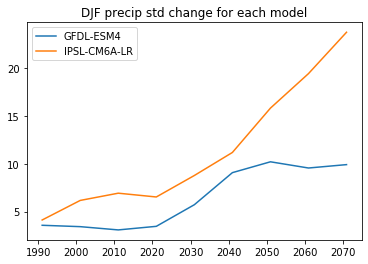

In [29]:
plt.plot((dsdG_djf_new-1)*100)
plt.title('DJF precip std change for each model')
plt.legend(dsdG_djf_new.columns)